# Galactic Science with **Point Of Interest** Broker

---


This example code shows how we calculate light-curve features, and how we cross-match alerts to external databases. Here the code is simply executed on one example alert `*.avro` file.




**Getting started**

Imports and function definitions.


In [ ]:
!pip install fastavro
!pip install aplpy
!pip install astroquery


     |████████████████████████████████| 2.2MB 9.4MB/s 
     |████████████████████████████████| 92kB 4.2MB/s 
     |████████████████████████████████| 378kB 12.6MB/s 
     |████████████████████████████████| 1.1MB 17.2MB/s 
     |████████████████████████████████| 1.3MB 27.9MB/s 
     |████████████████████████████████| 215kB 34.9MB/s 
  Created wheel for pyregion: filename=pyregion-2.0-cp37-cp37m-linux_x86_64.whl size=309316 sha256=f4cc77df9194de417a7a039a8a02a4f94fda17671f0eb4ee054b7254549eda6c
  Stored in directory: /root/.cache/pip/wheels/ca/2c/2b/c95350df7d42ba9044b7528c5ba549bead550433b189008a7f
Successfully built pyregion
     |████████████████████████████████| 6.5MB 7.1MB/s 
     |████████████████████████████████| 51kB 4.7MB/s 
     |████████████████████████████████| 3.2MB 47.1MB/s 
  Created wheel for astroquery: filename=astroquery-0.4.1-cp37-none-any.whl size=3831874 sha256=a2cb9c4e1ceae7363757057167ef3dc8319073bcd4779a9d82863871025acf94
  Stored in directory: /root/.cache/pip/wh

In [ ]:

import sys
import requests


from datetime import datetime, timedelta

import os
import io
import numpy as np

import pandas as pd
import matplotlib.pyplot as plt

import matplotlib

from pylab import figure, cm
from matplotlib.colors import LogNorm
import urllib

import fastavro

from astropy.time import Time
from astropy.io import fits
import aplpy

import gzip

		
from astropy.timeseries import TimeSeries
from astropy.timeseries import LombScargle

from scipy.optimize import leastsq
import scipy.stats as stats

from astroquery.simbad import Simbad
import astropy.coordinates as coord

from astropy.coordinates import SkyCoord

import astropy.units as units

import csv
import pickle   #need for serialization
from astroquery.ned import Ned
from astroquery.ned.core import RemoteServiceError

from urllib3.exceptions import ConnectTimeoutError
from urllib3.exceptions import ReadTimeoutError

from urllib.request import urlopen

In [ ]:

def generate_csv(s: str, lists: list) -> str:
    """ Make a string (CSV formatted) given lists of data and header.
    Parameters
    ----------
    s: str
        String which will contain the data.
        Should initially contain the CSV header.
    lists: list of lists
        List containing data.
        Length of `lists` must correspond to the header.

    Returns
    ----------
    s: str
        Updated string with one row per line.
    """
    output = io.StringIO()
    writer = csv.writer(output, quoting=csv.QUOTE_NONNUMERIC)

    _ = [writer.writerow(lists)]
    return s + output.getvalue().replace('\r', '')


def xmatch(
        ra: list, dec: list, id: list,
        extcatalog: str = "simbad", distmaxarcsec: int = 1) -> (list, list):
    """ Build a catalog of (ra, dec, id) in a CSV-like string,
    cross-match with `extcatalog`, and decode the output.

    See http://cdsxmatch.u-strasbg.fr/ for more information.

    Parameters
    ----------
    ra: list of float
        List of RA
    dec: list of float
        List of Dec of the same size as ra.
    id: list of str
        List of object ID (custom)
    extcatalog: str
        Name of the catalog to use for the xMatch.
        See http://cdsxmatch.u-strasbg.fr/ for more information.
    distmaxarcsec: int
        Radius used for searching match. extcatalog sources lying within
        radius of the center (ra, dec) will be considered as matches.

    Returns
    ----------
    data: list of string
        Unformatted decoded data returned by the xMatch
    header: list of string
        Unformatted decoded header returned by the xmatch

    """
    # Build a catalog of alert in a CSV-like string
    table_header = """ra_in,dec_in,objectId\n"""
    table = generate_csv(table_header, [ra, dec, id])

    # Send the request!
    r = requests.post(
        'http://cdsxmatch.u-strasbg.fr/xmatch/api/v1/sync',
        data={
            'request': 'xmatch',
            'distMaxArcsec': distmaxarcsec,
            'selection': 'all',
            'RESPONSEFORMAT': 'csv',
            'cat2': extcatalog,
            'colRA1': 'ra_in',
            'colDec1': 'dec_in'},
        files={'cat1': table})

    # Decode the message, and split line by line
    # First line is header - last is empty
    data = r.content.decode().split("\n")[1:-1]
    header = r.content.decode().split("\n")[0].split(",")

    return data, header


def cdsxmatch_simbad(objectId,ra,dec):
    """ Query the CDSXmatch service to find identified objects
    in alerts. The catalog queried is the SIMBAD bibliographical database.
    
    
    Parameters
    ----------
    oid: list of str
        List containing object ids (custom)
    ra: list of float
        List containing object ra coordinates
    dec: list of float
        List containing object dec coordinates

    Returns
    ----------
    out: List of Tuple
        Each tuple contains (objectId, ra, dec, name, type).
        If the object is not found in Simbad, name & type
        are marked as Unknown. In the case several objects match
        the centroid of the alert, only the closest is returned.
     """

    

    # Catch TimeoutError and ConnectionError
    try:
        data, header = xmatch(
            ra, dec, objectId, extcatalog='simbad', distmaxarcsec=1.5)
    except (ConnectionError, TimeoutError, ValueError) as ce:
        print('XMATCH failed')
        logging.error("CDS Simbad XMATCH failed for objectId %s, ra %.3f, dec %.3f" % (objectId,ra,dec) + repr(ce))
        return 'timeout','None'

    # Sometimes the service is down, but without TimeoutError or ConnectionError
    # In that case, we grab the error message from the data.
    if len(data) > 0 and "504 Gateway Time-out" in data[0]:
        msg = "CDS xmatch service probably down, check at http://cdsxmatch.u-strasbg.fr/xmatch/api/v1/sync"
        #print('CDS xmatch service probably down')
        logging.error("CSD Simbad XMATCH failed for objectId %s, ra %.3f, dec %.3f" % (objectId,ra,dec) + msg)
        return 'timeout',None

    if "main_id" not in header:
        print('main_id not in header')
        return "Unknown", None

    # Fields of interest (their indices in the output)
    main_id = header.index("main_id")
    main_type = header.index("main_type")
    oid_ind = header.index("objectId")

    # Get the objectId of matches
    id_out = [np.array(i.split(","))[oid_ind] for i in data]

    # Get the names of matches
    names = [np.array(i.split(","))[main_id] for i in data]

    # Get the types of matches
    types = [np.array(i.split(","))[main_type] for i in data]

    matches = []


    ra_in, dec_in = float(ra), float(dec)
    id_in = str(objectId)

        
    if id_in in id_out:
            # Return the closest object in case of many
            
            index = id_out.index(id_in)
            matches.append((
                id_in, ra_in, dec_in,
                str(names[index]), str(types[index])))

    else:
            # Mark as unknown if no match
            matches.append((id_in, ra_in, dec_in, "Unknown", None))


    if len(matches) > 0:

        objecttype = matches[0][-1]
        name = matches[0][-2]
        
    else:

        objecttype = "Fail"
        name = "Fail"
        

    return name, objecttype

def cdsxmatch_wise(objectId,ra,dec):
    """ Query the CDSXmatch service to find identified objects
    in alerts. The catalog queried is the SIMBAD bibliographical database.
    
    
    Parameters
    ----------
    oid: list of str
        List containing object ids (custom)
    ra: list of float
        List containing object ra coordinates
    dec: list of float
        List containing object dec coordinates

    Returns
    ----------
    out: List of Tuple
        Each tuple contains (objectId, ra, dec, name, type).
        If the object is not found in Simbad, name & type
        are marked as Unknown. In the case several objects match
        the centroid of the alert, only the closest is returned.
     """
    
    # Catch TimeoutError and ConnectionError
    try:
        data, header = xmatch(
            ra, dec, objectId, extcatalog="vizier:II/328/allwise", distmaxarcsec=1.5)
    except (ConnectionError, TimeoutError, ValueError) as ce:
        print("XMATCH failed " + repr(ce))
        
        print('XMATCH failed')
        logging.error("CDS WISE XMATCH failed for objectId %s, ra %.3f, dec %.3f" % (objectId,ra,dec) + repr(ce))
        
        return 'timeout',None,None,None,None
  
    # Sometimes the service is down, but without TimeoutError or ConnectionError
    # In that case, we grab the error message from the data.
    if len(data) > 0 and "504 Gateway Time-out" in data[0]:
        print('CDS xmatch service probably down')

        
        msg = "CDS xmatch service probably down, check at http://cdsxmatch.u-strasbg.fr/xmatch/api/v1/sync"
        #print('CDS xmatch service probably down')
        logging.error("CDS WISE XMATCH failed for objectId %s, ra %.3f, dec %.3f" % (objectId,ra,dec) + msg)
        
        return 'timeout',None,None,None,None
 
    if "AllWISE" not in header:
        print('ALLWISE not in header')	    
        return "Unknown", None,None,None,None
  ##
  
    # Fields of interest (their indices in the output)
    main_AllWISE = header.index("AllWISE")
    main_W1 = header.index("W1mag")
    main_W2 = header.index("W2mag")
    main_W3 = header.index("W3mag")
    main_W4 = header.index("W4mag")
    oid_ind = header.index("objectId")

    # Get the objectId of matches
    id_out = [np.array(i.split(","))[oid_ind] for i in data]

    # Get the names of matches
    AllWISE_s = [np.array(i.split(","))[main_AllWISE] for i in data]

    W1_s = [np.array(i.split(","))[main_W1] for i in data]
    W2_s = [np.array(i.split(","))[main_W2] for i in data]
    W3_s = [np.array(i.split(","))[main_W3] for i in data]
    W4_s = [np.array(i.split(","))[main_W4] for i in data]    


    # Assign names and types to inputs
    #matches = refine_search(ra, dec, objectId, id_out, names, types)
    

    matches = []

    ra_in, dec_in = float(ra), float(dec)
    id_in = str(objectId)


    if id_in in id_out:
            # Return the closest object in case of many
           
            index = id_out.index(id_in)
            matches.append((
                id_in, ra_in, dec_in,
                str(AllWISE_s[index]), W1_s[index],  W2_s[index],  W3_s[index],  W4_s[index]))

    else:
            # Mark as unknown if no match
            matches.append((id_in, ra_in, dec_in, "Unknown", None, None, None, None))


    if len(matches) > 0:
        # (objectId, ra, dec, name, type)
        # return only the type.
        
        AllWISE = matches[0][3]
        W1mag = matches[0][4]
        W2mag = matches[0][5]
        W3mag = matches[0][6]
        W4mag = matches[0][7]
       
    else:
        # Tag as Fail if the request failed.
        AllWISE = "Fail"
        W1mag= None
        W2mag= None
        W3mag= None
        W4mag= None
        
    return AllWISE, W1mag, W2mag, W3mag, W4mag

	
def cdsxmatch_2mass(objectId,ra,dec):
    """ Query the CDSXmatch service to find identified objects
    in alerts. The catalog queried is the SIMBAD bibliographical database.
    
    
    Parameters
    ----------
    oid: list of str
        List containing object ids (custom)
    ra: list of float
        List containing object ra coordinates
    dec: list of float
        List containing object dec coordinates

    Returns
    ----------
    out: List of Tuple
        Each tuple contains (objectId, ra, dec, name, type).
        If the object is not found in Simbad, name & type
        are marked as Unknown. In the case several objects match
        the centroid of the alert, only the closest is returned.
     """
    
    
    """
    
https://dc.zah.uni-heidelberg.de/2mass/res/2mass/q/info
Qflg quality flag
Bflg blend flag
Cflg 	confusion contamination 	Contamination and confusion flag
Xflg 	ext. src contamination 	Extended source contamination 
Aflg 	solar system flag 	Association with asteroid or comet 
      
    
    """
    
    # Catch TimeoutError and ConnectionError
    try:
        data, header = xmatch(
            ra, dec, objectId, extcatalog="vizier:II/246/out", distmaxarcsec=1.5)
    except (ConnectionError, TimeoutError, ValueError) as ce:
        print("XMATCH failed " + repr(ce))
        logging.error("CDS 2MASS XMATCH failed for objectId %s, ra %.3f, dec %.3f" % (objectId,ra,dec) + repr(ce))

        return 'timeout',None,None,None,None,None,None
  

    # Sometimes the service is down, but without TimeoutError or ConnectionError
    # In that case, we grab the error message from the data.
    if len(data) > 0 and "504 Gateway Time-out" in data[0]:
        msg = "CDS xmatch service probably down, check at http://cdsxmatch.u-strasbg.fr/xmatch/api/v1/sync"
        #print('CDS xmatch service probably down')
        logging.error("CDS 2MASS XMATCH failed for objectId %s, ra %.3f, dec %.3f" % (objectId,ra,dec) + msg)
      
        return 'timeout',None,None,None,None,None,None
    

    # Fields of interest (their indices in the output)
    if "2MASS" not in header:
        print('2MASS not in header')
        return "Unknown", None, None, None, None, None, None


    # Fields of interest (their indices in the output)
    main_angDist = header.index("angDist")
    main_2MASS = header.index("2MASS")
    main_Jmag = header.index("Jmag")
    main_Hmag = header.index("Hmag")
    main_Kmag = header.index("Kmag")
    main_Qfl = header.index("Qfl")
    main_Rfl = header.index("Rfl")
    oid_ind = header.index("objectId")



# columns I get from API:
# 'angDist', 'ra_in', 'dec_in', 'objectId', '2MASS', 'RAJ2000', 'DEJ2000', 'errHalfMaj', 'errHalfMin', 'errPosAng', 'Jmag', 'Hmag', 'Kmag', 'e_Jmag', 'e_Hmag', 'e_Kmag', 'Qfl', 'Rfl', 'X', 'MeasureJD'



#RAJ2000,DEJ2000,errMaj,errMin,errPA,2MASS,Jmag,Jcmsig,e_Jmag,Jsnr,Hmag,Hcmsig,e_Hmag,Hsnr,Kmag,Kcmsig,e_Kmag,
#Ksnr,Qflg,Rflg,Bflg,Cflg,Ndet,prox,pxPA,pxCntr,Xflg,Aflg,Cntr,Hemis,Date,Scan,GLON,GLAT,Xscan,JD,Jpsfchi,Hpsfchi,Kpsfchi,Jstdap,e_Jstdap,Hstdap,e_Hstdap,Kstdap,e_Kstdap,edgeNS,edgeEW,edge,dup,use,opt,Dopt,PAopt,Bmag,Rmag,Nopt,extKey,scanKey,coaddKey,coadd


    # Get the objectId of matches
    id_out = [np.array(i.split(","))[oid_ind] for i in data]

    # Get the names of matches
    angDist_s = [np.array(i.split(","))[main_angDist] for i in data]
    twoMASS_s = [np.array(i.split(","))[main_2MASS] for i in data]
    Jmag_s = [np.array(i.split(","))[main_Jmag] for i in data]
    Hmag_s = [np.array(i.split(","))[main_Hmag] for i in data]
    Kmag_s = [np.array(i.split(","))[main_Kmag] for i in data]    
    Qfl_s = [np.array(i.split(","))[main_Qfl] for i in data]
    Rfl_s = [np.array(i.split(","))[main_Rfl] for i in data]
    
    
    matches = []
    
    ra_in, dec_in = float(ra), float(dec)
    id_in = str(objectId)

    if id_in in id_out:
            # Return the closest object in case of many

            index = id_out.index(id_in)
            matches.append((
                id_in, ra_in, dec_in,
                str(twoMASS_s[index]), angDist_s[index], Jmag_s[index], Hmag_s[index], Kmag_s[index], Qfl_s[index], Rfl_s[index]))

    else:
            # Mark as unknown if no match
            matches.append((id_in, ra_in, dec_in, "Unknown", None,None,None,None,None,None))

    if len(matches) > 0:
        
        twoMASS = matches[0][3]
        angDist =  matches[0][4]
        Jmag = matches[0][5]
        Hmag = matches[0][6]
        Kmag = matches[0][7]
        Qfl = matches[0][8]
        Rfl = matches[0][9]
      
    else:
        # Tag as Fail if the request failed.
        
        twoMASS="Unknown"
        angDist=None
        Jmag=None
        Hmag=None
        Kmag=None
        Qfl=None
        Rfl=None

        
    return twoMASS, angDist, Jmag, Hmag, Kmag, Qfl, Rfl


      
      
def cdsxmatch_vsx(objectId,ra,dec):
    """ Query the CDSXmatch service to find identified objects
    in alerts. The catalog queried is the SIMBAD bibliographical database.
    
    
    Parameters
    ----------
    oid: list of str
        List containing object ids (custom)
    ra: list of float
        List containing object ra coordinates
    dec: list of float
        List containing object dec coordinates

    Returns
    ----------
    out: List of Tuple
        Each tuple contains (objectId, ra, dec, name, type).
        If the object is not found in Simbad, name & type
        are marked as Unknown. In the case several objects match
        the centroid of the alert, only the closest is returned.
     """
    
    
    
    # Catch TimeoutError and ConnectionError
    try:
        data, header = xmatch(
            ra, dec, objectId, extcatalog="vizier:B/vsx/vsx", distmaxarcsec=1.5)
    except (ConnectionError, TimeoutError, ValueError) as ce:
        print("XMATCH failed " + repr(ce))
        logging.error("CDS VSX XMATCH failed for objectId %s, ra %.3f, dec %.3f" % (objectId,ra,dec) + repr(ce))

        return 'timeout',None,None,None
  
    # Sometimes the service is down, but without TimeoutError or ConnectionError
    # In that case, we grab the error message from the data.
    if len(data) > 0 and "504 Gateway Time-out" in data[0]:
        msg = "CDS xmatch service probably down, check at http://cdsxmatch.u-strasbg.fr/xmatch/api/v1/sync"
        #print('CDS xmatch service probably down')
        logging.error("CDS VSX XMATCH failed for objectId %s, ra %.3f, dec %.3f" % (objectId,ra,dec) + msg)
        
        return 'timeout',None,None,None



    # Fields of interest (their indices in the output)
    if "OID" not in header:
        print('OID not in header')
        return "Unknown", None, None, None

    # Fields of interest (their indices in the output)
    main_OID = header.index("OID")
    main_Name = header.index("Name")
    main_V = header.index("V")
    main_Type = header.index("Type")
   
    oid_ind = header.index("objectId")
	#OID		internal identifier, to get the VSX URL, add the OID to http://www.aavso.org/vsx/index.php?view=detail.top&oid=
	#Name
	#V		variability flag,  0 = Variable,1 = Suspected variable,2 = Constant or non-existing,3 = Possible duplicate 
	#Type		Variability type, as in GCVS catalog Variability type (see details of VSX type list)
	

    # Get the objectId of matches
    id_out = [np.array(i.split(","))[oid_ind] for i in data]

    # Get the names of matches

    OID_s = [np.array(i.split(","))[main_OID] for i in data]
    Name_s = [np.array(i.split(","))[main_Name] for i in data]
    V_s = [np.array(i.split(","))[main_V] for i in data]
    Type_s = [np.array(i.split(","))[main_Type] for i in data]    

    matches = []

    ra_in, dec_in = float(ra), float(dec)
    id_in = str(objectId)

        # Discriminate with the objectID
        
    #print('id_out ', id_out)
    if id_in in id_out:
            # Return the closest object in case of many
            index = id_out.index(id_in)
            matches.append((
                id_in, ra_in, dec_in,
                str(OID_s[index]), Name_s[index], V_s[index], Type_s[index]))
    else:
            # Mark as unknown if no match
            matches.append((id_in, ra_in, dec_in, "Unknown", None,None,None))


    if len(matches) > 0:
        
        OID = matches[0][3]
        Name = matches[0][4]
        V = matches[0][5]
        Type = matches[0][6]
	
    else:
        # Tag as Fail if the request failed.
        
        OID = "Unknown"
        Name = None
        V = None
        Type =None
        
        
        
# V is the variability flag:        
#0 = Variable,
#1 = Suspected variable,
#2 = Constant or non-existing,
#3 = Possible duplicate 
        
    return OID, Name, V, Type
  
	


						
def make_dataframe(packet):
	
# packet['candidate'] and packet['prv_candidates'] contain a 30-day light curve
    df = pd.DataFrame(packet['candidate'], index=[0])
    df_prv = pd.DataFrame(packet['prv_candidates'])
    return pd.concat([df,df_prv], ignore_index=True,sort=True)
	
	

def bincalc(nbin=0.1, bmin=5, bmax=2000):
	"""
	calculate the bin range, in logscale
	inputs:
	nbin: size of the bin in log scale
	bmin: minimum value of the bins
	bmax: maximum value of the bins
	output: bins array
	"""
	logbmin = np.log10(bmin)
	logbmax = np.log10(bmax)

	logbins = np.arange(logbmin, logbmax, nbin)

	bins = 10**logbins
	return bins

def plot_lightcurve(dflc, objectId):
    
	len_good = ( len(  dflc[dflc.isdiffpos.notnull() & (dflc.magnr>0) & (dflc.magpsf>0)] ) )
	
	if(len_good>1):
		
		filter_color = {1:'green', 2:'red', 3:'pink'}
		
		t = dflc.jd - 2400000.5
		

		fig = plt.figure(figsize=(5.5,3))
		
		fig.subplots_adjust(left=0.13, right=0.95, top=0.92, bottom=0.17, hspace = 0.4)

	
	
		if (np.max(dflc['distnr']<1.5)):
					
						
			for fid, color in filter_color.items():
				# plot detections in this filter:
				w = (dflc.fid == fid) & ~dflc.magpsf.isnull()
			
				if np.sum(w):
					plt.errorbar(t[w],dflc.loc[w,'dc_mag'], dflc.loc[w,'dc_sigmag'],fmt='.',color=color)
				wnodet = (dflc.fid == fid) & dflc.magpsf.isnull()
				
				
				if np.sum(wnodet):
					plt.scatter(t[wnodet],dflc.loc[wnodet,'dc_mag_ulim'], marker='v',color=color,alpha=0.25)
					plt.scatter(t[wnodet],dflc.loc[wnodet,'dc_mag_llim'], marker='^',color=color,alpha=0.25)
					
					plt.ylabel('dc mag')		

		else:
			
			for fid, color in filter_color.items():
				# plot detections in this filter:
				w = (dflc.fid == fid) & ~dflc.magpsf.isnull()
				if np.sum(w):
					plt.errorbar(t[w],dflc.loc[w,'magpsf'], dflc.loc[w,'sigmapsf'],fmt='.',color=color)
				wnodet = (dflc.fid == fid) & dflc.magpsf.isnull()
				if np.sum(wnodet):
					plt.scatter(t[wnodet],dflc.loc[wnodet,'diffmaglim'], marker='v',color=color,alpha=0.25)
				plt.ylabel('psf mag')		
					
		
		plt.gca().invert_yaxis()

		plt.xlabel('time (MJD)')
		plt.ylabel('dc Magnitude')		
		
		fig.show()


def SFarray(jd, mag, err):
	"""
	calculate an array with (m(ti)-m(tj)), with (err(t)^2+err(t+tau)^2) and another with tau=dt
	inputs:
	jd: julian days array
	mag: magnitudes array
	err: error of magnitudes array
	outputs:
	tauarray: array with the difference in time (ti-tj)
	sfarray: array with |m(ti)-m(tj)|
	errarray: array with err(ti)^2+err(tj)^2
	"""

	sfarray = []
	tauarray = []
	errarray = []
	err_squared = err**2
	len_mag = len(mag)
	for i in range(len_mag):
		for j in range(i+1, len_mag):
			#print('for magdiff: ', i,j,mag[i],mag[j])
			dm = mag[i] - mag[j]
			sigma = err_squared[i] + err_squared[j]
			dt = jd[j] - jd[i]
			sfarray.append(np.abs(dm))
			tauarray.append(dt)
			errarray.append(sigma)
	sfarray = np.array(sfarray)
	tauarray = np.array(tauarray)
	errarray = np.array(errarray)
	return tauarray, sfarray, errarray


def SF_formula(jd, mag, errmag, nbin=0.1, bmin=5, bmax=2000):
        dtarray, dmagarray, sigmaarray = SFarray(jd, mag, errmag)
        ndt = np.where((dtarray <= 365) & (dtarray >= 5))
        dtarray = dtarray[ndt]
        dmagarray = dmagarray[ndt]
        sigmaarray = sigmaarray[ndt]

        bins = bincalc(nbin, bmin, bmax)

        sf_list = []
        tau_list = []
        numobj_list = []

        for i in range(0, len(bins)-1):
            n = np.where((dtarray >= bins[i]) & (dtarray < bins[i+1]))
            nobjbin = len(n[0])
            if nobjbin >= 1:
                dmag1 = (dmagarray[n])**2
                derr1 = (sigmaarray[n])
                sf = (dmag1-derr1)
                sff = np.sqrt(np.mean(sf))
                sf_list.append(sff)
                numobj_list.append(nobjbin)
                # central tau for the bin
                tau_list.append((bins[i]+bins[i+1])*0.5)

        SF = np.array(sf_list)
        nob = np.array(numobj_list)
        tau = np.array(tau_list)
        nn = np.where((nob > 0) & (SF > -99))
        tau = tau[nn]
        SF = SF[nn]

        if len(SF) < 2:
            tau = np.array([-99])
            SF = np.array([-99])

        return tau/365., SF
  
  
	
	
def get_stetson_k(mag, avg, err):
        """
        Return Stetson K feature.
        Parameters
        ----------
        mag : array_like
            An array of magnitude.
        avg : float
            An average value of magnitudes.
        err : array_like
            An array of magnitude errors.
        Returns
        -------
        stetson_k : float
            Stetson K value.
        """

        residual = (mag - avg) / err
        stetson_k = np.sum(np.fabs(residual)) \
                    / np.sqrt(np.sum(residual * residual)) / np.sqrt(len(mag))

        return stetson_k	
  
  
def slope_percentile(time, mag):
        """
        Return 10% and 90% percentile of slope.
        Parameters
        ----------
        time : array_like
            An array of phase-folded time. Sorted.
        mag : array_like
            An array of phase-folded magnitudes. Sorted by time.
        Returns
        -------
        per_10 : float
            10% percentile values of slope.
        per_90 : float
            90% percentile values of slope.
        """

        date_diff = time[1:] - time[:len(time) - 1]
        mag_diff = mag[1:] - mag[:len(mag) - 1]

        # Remove zero mag_diff.
        index = np.where(mag_diff != 0.)
        date_diff = date_diff[index]
        mag_diff = mag_diff[index]

        # Derive slope.
        slope = date_diff / mag_diff

        percentile_10 = np.percentile(slope, 10.)
        percentile_90 = np.percentile(slope, 90.)

        return percentile_10, percentile_90  
  


def generate_dcmag_lightcurve(dflc):

	len_good = ( len(  dflc[dflc.isdiffpos.notnull() & (dflc.magnr>0) & (dflc.magpsf>0)] ) )
	
	
	if(len_good>1):
		
		# confirm that the nearest reference source from ZTF is  coincident
		if (np.max(dflc['distnr']<1.5)):
			
				
			grp = dflc.groupby(['fid','field','rcid'])
			
			
			#impute only possible if at min 2 for each fid,field
			

			try:
				impute_magnr = grp['magnr'].agg(lambda x: np.median(x[pd.notnull(x)]))
		
				impute_sigmagnr = grp['sigmagnr'].agg(lambda x: np.median(x[pd.notnull(x)]))
				
				for idx, grpi in grp:
					#w = np.isnan(grpi['magnr'])
					
					w = pd.isnull(grpi['magnr'])
					
					w2 = grpi[w].index
					dflc.loc[w2,'magnr'] = impute_magnr[idx]
					dflc.loc[w2,'sigmagnr'] = impute_sigmagnr[idx]

			except:
				pass
			
			
			dflc['sign'] = 2* (dflc['isdiffpos'] == 't') - 1

			u = (10**(-0.4*dflc['magnr']) + dflc['sign'] * 10**(-0.4*dflc['magpsf'])).astype(np.float64)
			
			
			dflc['dc_mag'] = -2.5 * np.log10(u)
			dflc['dc_sigmag'] = np.sqrt(
			(10**(-0.4*dflc['magnr'].astype(np.float64))* dflc['sigmagnr'].astype(np.float64)) **2. + 
			(10**(-0.4*dflc['magpsf'].astype(np.float64)) * dflc['sigmapsf'].astype(np.float64))**2.) / u
			dflc['dc_mag_ulim'] = -2.5 * np.log10(10**(-0.4*dflc['magnr'].astype(np.float64)) + 10**(-0.4*dflc['diffmaglim'].astype(np.float64)))
			dflc['dc_mag_llim'] = -2.5 * np.log10(10**(-0.4*dflc['magnr'].astype(np.float64)) - 10**(-0.4*dflc['diffmaglim'].astype(np.float64)))
			
	return dflc	
		
		
def calculate_features(dflc):	
	

	
	feature_array = np.empty(24)
	feature_array[:] = np.NaN
	
	len_good = ( len(  dflc[dflc.isdiffpos.notnull() & (dflc.magnr>0) & (dflc.magpsf>0)] ) )
	
	
	if(len_good>1):
	
		if (np.max(dflc['distnr']<1.5)):
							
			mag_all = dflc['dc_mag'].values
			sigma_mag_all = dflc['dc_sigmag'].values
			t_all = dflc['jd'].values

			mag_g = dflc.loc[( (dflc.fid == 1)& ~dflc.dc_mag.isnull()),'dc_mag'].values
			mag_r = dflc.loc[( (dflc.fid == 2)& ~dflc.dc_mag.isnull()),'dc_mag'].values
			mag_i = dflc.loc[( (dflc.fid == 3)& ~dflc.dc_mag.isnull()),'dc_mag'].values
				
			sigma_mag_g = dflc.loc[( (dflc.fid == 1)& ~dflc.dc_mag.isnull()),'dc_sigmag'].values
			sigma_mag_r = dflc.loc[( (dflc.fid == 2)& ~dflc.dc_mag.isnull()),'dc_sigmag'].values
			sigma_mag_i = dflc.loc[( (dflc.fid == 3)& ~dflc.dc_mag.isnull()),'dc_sigmag'].values
					
			t_g = dflc.loc[( (dflc.fid == 1)& ~dflc.dc_mag.isnull()),'jd'].values
			t_r = dflc.loc[( (dflc.fid == 2)& ~dflc.dc_mag.isnull()),'jd'].values
			t_i = dflc.loc[( (dflc.fid == 3)& ~dflc.dc_mag.isnull()),'jd'].values
					
		else:
					
			mag_all = dflc['magpsf'].values
			sigma_mag_all= dflc['sigmapsf'].values
			t_all = dflc['jd'].values
				
			mag_g = dflc.loc[( (dflc.fid == 1)& ~dflc.magpsf.isnull()),'magpsf'].values
			mag_r = dflc.loc[( (dflc.fid == 2)& ~dflc.magpsf.isnull()),'magpsf'].values
			mag_i = dflc.loc[( (dflc.fid == 3)& ~dflc.magpsf.isnull()),'magpsf'].values
				
			sigma_mag_g = dflc.loc[( (dflc.fid == 1)& ~dflc.magpsf.isnull()),'sigmapsf'].values
			sigma_mag_r = dflc.loc[( (dflc.fid == 2)& ~dflc.magpsf.isnull()),'sigmapsf'].values
			sigma_mag_i = dflc.loc[( (dflc.fid == 3)& ~dflc.magpsf.isnull()),'sigmapsf'].values
					
			t_g = dflc.loc[( (dflc.fid == 1)& ~dflc.magpsf.isnull()),'jd'].values
			t_r = dflc.loc[( (dflc.fid == 2)& ~dflc.magpsf.isnull()),'jd'].values
			t_i = dflc.loc[( (dflc.fid == 3)& ~dflc.magpsf.isnull()),'jd'].values	


		#print('mag_g size: ', mag_g.size)
		
		#print('mag_r size: ', mag_r.size)
		
		
		
		#$\omega$ &  structure function amplitude\\
		#$\tau$ & structure function timescale\\
		
		A_sf_g = np.NaN
		gamma_sf_g = np.NaN
		A_sf_r = np.NaN
		gamma_sf_r = np.NaN
				
		if(mag_g.size>5):
			mag = mag_g
			t = t_g
			err = sigma_mag_g

			tau, sf = SF_formula(t, mag, err)
			#print('tau, sf ', tau, sf)
			if tau[0] == -99:
				A = -0.5
				gamma = -0.5

			else:
				y = np.log10(sf)
				x = np.log10(tau)
				
				x = x[np.where((tau <= 0.5) & (tau > 0.01))]
				y = y[np.where((tau <= 0.5) & (tau > 0.01))]
				try:
					coefficients = np.polyfit(x, y, 1)
					A = 10**(coefficients[1])
					gamma = coefficients[0]

					print('A, gamma ', A, gamma)
					if A < 0.005:
						A = 0.0
						gamma = 0.0
					elif A > 15:
						A = 15
					if gamma > 3:
						gamma = 3
					elif gamma < -0.5:
						gamma = -0.5

				except:
					A = -0.5
					gamma = -0.5

			A_sf_g = A
			gamma_sf_g = gamma
			
		
		
		if(mag_r.size>5):
			mag = mag_r
			t = t_r
			err = sigma_mag_r

			tau, sf = SF_formula(t, mag, err)

			if tau[0] == -99:
				A = -0.5
				gamma = -0.5

			else:
				y = np.log10(sf)
				x = np.log10(tau)
				
				x = x[np.where((tau <= 0.5) & (tau > 0.01))]
				y = y[np.where((tau <= 0.5) & (tau > 0.01))]
				try:
					coefficients = np.polyfit(x, y, 1)
					A = 10**(coefficients[1])
					gamma = coefficients[0]

					if A < 0.005:
						A = 0.0
						gamma = 0.0
					elif A > 15:
						A = 15
					if gamma > 3:
						gamma = 3
					elif gamma < -0.5:
						gamma = -0.5

				except:
					A = -0.5
					gamma = -0.5

			A_sf_r = A
			gamma_sf_r = gamma
			
		
		sigmaDRW_g = np.NaN
		tauDRW_g = np.NaN
		
		sigmaDRW_r = np.NaN
		tauDRW_r = np.NaN
		
		if(mag_g.size>5):
			try:
				
				magnitude = mag_g
				t = t_g
				err = sigma_mag_g

				mag_d = magnitude-magnitude.mean()
				kern = GPy.kern.OU(1)
				m = GPy.models.GPHeteroscedasticRegression(t[:, None], mag_d[:, None], kern)


				m['.*het_Gauss.variance'] = abs(err ** 2.)[:, None]  # Set the noise parameters to the error in Y
				m.het_Gauss.variance.fix()  # We can fix the noise term, since we already know it
				m.optimize()
				pars = [m.OU.variance.values[0], m.OU.lengthscale.values[0]]  # sigma^2, tau

				sigmaDRW_g = pars[0]
				tauDRW_g = pars[1]
				

					
			except:
				pass
				#print('cannot calculate DRW')
				
				
		if(mag_r.size>5):
			try:
				
				magnitude = mag_r
				t = t_r
				err = sigma_mag_r

				mag_d = magnitude-magnitude.mean()
				kern = GPy.kern.OU(1)
				m = GPy.models.GPHeteroscedasticRegression(t[:, None], mag_d[:, None], kern)

				# DeprecationWarning:Assigning the 'data' attribute is an inherently
				# unsafe operation and will be removed in the future.

				m['.*het_Gauss.variance'] = abs(err ** 2.)[:, None]  # Set the noise parameters to the error in Y
				m.het_Gauss.variance.fix()  # We can fix the noise term, since we already know it
				m.optimize()
				pars = [m.OU.variance.values[0], m.OU.lengthscale.values[0]]  # sigma^2, tau

				sigmaDRW_r = pars[0]
				tauDRW_r = pars[1]
				
					
			except:
				pass
				#print('cannot calculate DRW')
				
				
		#$g-r$ & color\\

		if ((mag_g.size>0) & (mag_r.size>0)):
			
			gr=np.mean(mag_g) - np.mean(mag_r)
			
		else:
			gr=np.NaN
		
		#$r-i$ & color\\
		if ((mag_r.size>0) & (mag_i.size>0)):
			ri=np.mean(mag_r) - np.mean(mag_i)
		else:
			ri=np.NaN
		
		#$A$    &   Amplitude\\
		
		A_g=np.NaN
		if(mag_g.size>1):
			A_g = np.max(mag_g)-np.min(mag_g)
		
		A_r=np.NaN
		if(len(mag_r)>1):
			A_r = np.max(mag_r)-np.min(mag_r)
		
		
		#$P$   & 	Period derived by the Lomb-Scargle algorithm\\
		
		P=np.NaN
		
		if (mag_g.size>10):
			
			frequency, power = LombScargle(t_g,mag_g).autopower(minimum_frequency=0.1, maximum_frequency=15)		

			bestfreq=frequency[np.argmax(power)]
			best_fourier_period = 1./bestfreq
			
			P = best_fourier_period
					

		##$H_1$ 	& Amplitude derived using the Fourier decomposition\\
		#$R_{21}$ &	2nd to 1st amplitude ratio derived using the Fourier decomposition
		#R12 = np.sqrt ((A1*A1 + B1*B1) / (A2*A2+ + B2*B2)  )
		#$R_{31}$ &	3rd to 1st amplitude ratio derived using the Fourier decomposition
		#$\phi_{21}$ &	Difference between 2nd and 1st phase derived using the Fourier decomposition
		#$\phi_{31}$ &	Difference between 3rd and 1st phase derived using the Fourier decomposition
		
		
		
		#H1=np.sqrt(a1*a1+b1*b1)
		H1=np.NaN
		R21=np.NaN
		R31=np.NaN
		phi21=np.NaN
		phi31=np.NaN
		
		if (mag_g.size>10):
			
			# Fit Fourier Series of order 3.
			order = 3
			# Initial guess of Fourier coefficients.
			p0 = np.ones(order * 2 + 1)
			time_period = (t_g % P) / P
			p1, success = leastsq(residuals, p0,
							args=(time_period, mag_g, order))


			# Derive Fourier features for the first period.
			# Petersen, J. O., 1986, A&A
			H1 = np.sqrt(p1[1] ** 2 + p1[2] ** 2)
			R21 = np.sqrt(p1[3] ** 2 + p1[4] ** 2) / H1
			R31 = np.sqrt(p1[5] ** 2 + p1[6] ** 2) / H1
			f_phase = np.arctan(-p1[1] / p1[2])
			phi21 = np.arctan(-p1[3] / p1[4]) - 2. * f_phase
			phi31 = np.arctan(-p1[5] / p1[6]) - 3. * f_phase

	
		#$\gamma_1$ 	& Skewness\\
		gamma1=np.NaN
		
		if (mag_g.size>10):
			gamma1=stats.skew(mag_g)
		
		#$\gamma_2$ &	Kurtosis\\
		gamma2=np.NaN
	
		if (mag_g.size>10):
			gamma2=stats.kurtosis(mag_g)
					
		#$K$ &	Stetson K index\\
		K=np.NaN
		
	
		# Simple statistics, mean, median and std.
		if(mag_g.size>1):
			mean_g = np.mean(mag_g)
			median_g = np.median(mag_g)
			std_g = np.std(mag_g)

		if (mag_g.size>10):
			K=get_stetson_k(mag_g,median_g,sigma_mag_g)
					
		#$Q_{31}$ &	3rd quartile (75%) – 1st quartile (25%)
		Q31=np.NaN
		
		if(mag_g.size>5):
			Q31 = np.percentile(mag_g, 75) - np.percentile(mag_g, 25)
		
		#print('Q31 ', Q31)
		#$p_{10}$ &	10\% percentile of slopes of a phase-folded light curve
		p10=np.NaN
		
		#$p_{90}$ &	90\% percentile of slopes of a phase-folded light curve
		p90=np.NaN
		
		if (mag_g.size>10):
		

			# We use period * 2 to take eclipsing binaries into account.
			phase_folded_date = t_g % (P * 2.)
			sorted_index = np.argsort(phase_folded_date)

			folded_t_g = phase_folded_date[sorted_index]
			folded_mag_g = mag_g[sorted_index]
			
			p10, p90 = slope_percentile(folded_t_g, folded_mag_g)
						
			
		feature_array = [A_sf_g,gamma_sf_g,A_sf_r,gamma_sf_r,sigmaDRW_g,tauDRW_g,sigmaDRW_r,tauDRW_r,gr,ri,A_r,A_g,P,H1,R21,R31,phi21,phi31,gamma1,gamma2,K,Q31,p10,p90]
	
	return feature_array

**Load external astronomical databases for cross-matching**

In some cases we can access such databases like SIMBAD. For others it is more convenient and faster to have them locally. Let's load those data:

In [ ]:

url_ps1rrlyr = "https://drive.google.com/file/d/1fGQxmeW9k0UFR2HPvgGqU3xLL0jpxU3I/view?usp=sharing"
path_ps1rrlyr = 'https://drive.google.com/uc?export=download&id='+url_ps1rrlyr.split('/')[-2]

url_asassn_catalog ="https://drive.google.com/file/d/1r6_5ds5kyLg-uIMryfNWJYxHtHyJNRj8/view?usp=sharing"
path_asassn_catalog = 'https://drive.google.com/uc?export=download&id='+url_asassn_catalog.split('/')[-2]

url_twomass_catalog ="https://drive.google.com/file/d/1SImJ31RSKYElvfbVoIPnYSqOVJbsE8vt/view?usp=sharing"
path_twomass_catalog = 'https://drive.google.com/uc?export=download&id='+url_twomass_catalog.split('/')[-2]

PS1_final_RRLyr_candidates_RRab = np.genfromtxt(path_ps1rrlyr, names = 'ra,dec,P,helio_dist', usecols = (0,1,2,12), dtype = 'f8, f8, f8, f8', skip_header=1,delimiter=',')    
	
PS1_RRL_catalog = SkyCoord(ra=PS1_final_RRLyr_candidates_RRab['ra']*units.degree, dec=PS1_final_RRLyr_candidates_RRab['dec']*units.degree)
	
print('PS1 loaded')

twomass_Aflg_eq_1 = np.genfromtxt(path_twomass_catalog,skip_header=0, dtype='unicode')#dtype='|S16')

print('2MASS loaded')
	
asassn_catalog = np.genfromtxt(path_asassn_catalog, \
			names = 'asassn_name,OtherNames,raj2000,dej2000,amplitude,period,Type,class_probability,Periodic,Classified,ASASSN_Discovery',
			dtype = 'U30,U30,f8,f8,f8,f8,U20,f8,U5,U5,U5', skip_header=1,delimiter=',')    


print('ASA_SSN loaded')
    
    



PS1 loaded
2MASS loaded
ASA_SSN loaded


Some databases are available online, whereas for others, it is more convenient to have them lokal. This is here the case for the PS1 Catalog of RR Lyrae stars, 2MASS and ASA-SSN. As we now have all libraries imported, functions defined and databases loaded, we start with processing an alert.

**Load *.avro alert**

Here, we are just loading one ZTF alert for demonstration.

In [ ]:

url_avro ="https://drive.google.com/file/d/1QrvPwEanp0JE9x1Bm25SP_-A_ez1tXzm/view?usp=sharing"
path_avro = 'https://drive.google.com/uc?export=download&id='+url_avro.split('/')[-2]

In [ ]:

f = urllib.request.urlopen(path_avro)
		
freader = fastavro.reader(f)
schema = freader.schema

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: DeprecationWarning: The 'schema' attribute is deprecated. Please use 'writer_schema'
  """


In [ ]:
for packet in freader:
						
			candid = packet['candid']
							
			objectId = packet['objectId']
			print('candid ',candid)
			print('objectId ', objectId)

candid  1539147085215015022
objectId  ZTF18acuzzkn


**Plotting**

We do some basic plot: first the cutout image, then a plot of the light curve.

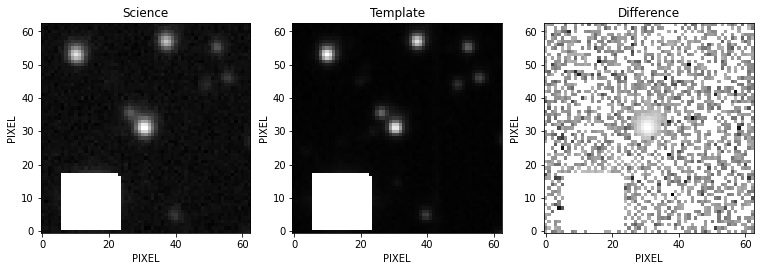

In [ ]:
	
# plot cutout image
fig_stamp, axs_stamp = plt.subplots(1,3,figsize=(11,4))
fig_stamp.subplots_adjust(left=0.05, right=0.95, top=0.94, bottom=0.08, hspace = 0.4)
													
axs_stamp[0].title.set_text('Science')
axs_stamp[0].set_xlabel('PIXEL')
axs_stamp[0].set_ylabel('PIXEL')

axs_stamp[1].title.set_text('Template')
axs_stamp[1].set_xlabel('PIXEL')
axs_stamp[1].set_ylabel('PIXEL')
																
axs_stamp[2].title.set_text('Difference')
axs_stamp[2].set_xlabel('PIXEL')
axs_stamp[2].set_ylabel('PIXEL')
    
	
for i, cutout in enumerate(['Science','Template','Difference']):
				stamp = packet['cutout{}'.format(cutout)]['stampData']
							
				with gzip.open(io.BytesIO(stamp), 'rb') as f:
					with fits.open(io.BytesIO(f.read())) as hdul:
										
												
						image_data = hdul[0].data
										
						if(np.min(image_data)<0):
								image_data = image_data+np.min(image_data)
										
						axs_stamp[i].imshow(image_data,origin='lower',cmap=cm.gray, norm=LogNorm())
										
							# show the cutout image	
plt.show()




For plotting the light curve, we first generate it from the data stored in the alert. The alert already comes with a 30 day long light-curve history. In the broker, at that step we concatenate the light curve with those from previous alerts of the same object (here we are obmitting this step). What we do in addition to concatenating is computing a DC magnitude.

ZTF itself provides a difference magnitude. The DC magnitude calculated here makes use of the reference magnitude of the nearest objet at a reference epoch. Also zero-point magnitudes are calculated.

A, gamma  0.0004281080640261274 -1.122408780303756
[0.0, 0.0, 15, 2.0411788770324817, nan, nan, nan, nan, 2.067757060024629, nan, 0.26025843259191284, 0.2777924139439012, nan, nan, nan, nan, nan, nan, nan, nan, nan, 0.03403455742915895, nan, nan]
structure function parameters
A_sf_g  0.0
gamma_sf_g  0.0
A_sf_r  15
gamma_sf_r  2.0411788770324817
sigmaDRW_g  nan
tauDRW_g  nan
sigmaDRW_r  nan
tauDRW_r  nan
colors
gr  2.067757060024629
ri  nan
amplitudes
A_r  0.26025843259191284
A_g  0.2777924139439012
Lomb-Scargle P  nan
amplitudes from Fourier decomposition
H1  nan
R21  nan
R31  nan
phi21  nan
phi31  nan
Skewness gamma1  nan
Kurtosis gamma2  nan
Stetson index K  nan
quartile Q31  0.03403455742915895
10% percentile of slopes p10  nan
90% percentile of slopes p90  nan


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:688: RuntimeWarning: invalid value encountered in sqrt


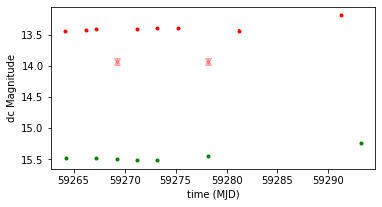

In [ ]:
# generate light curve
							
dflc = make_dataframe(packet)

								
dflc = generate_dcmag_lightcurve(dflc)
							
# plot light curve
plot_lightcurve(dflc,objectId)
								
					
			
		
		

**Feature calculation**

Now *features* are calculated. Features, sometimes also called *metrics*, describe the light-curve characteristics and behavior over time. Common ones are such as amplitudes or periods. We use a few more, see below, to later on provide them to a classifier.

In [ ]:
			
# calculate features
feature_array = calculate_features(dflc)
print(feature_array)
			
print('structure function parameters')
print('A_sf_g ', feature_array[0])
print('gamma_sf_g ', feature_array[1])
print('A_sf_r ', feature_array[2])
print('gamma_sf_r ', feature_array[3])
print('sigmaDRW_g ', feature_array[4])
print('tauDRW_g ', feature_array[5])
print('sigmaDRW_r ', feature_array[6])
print('tauDRW_r ', feature_array[7])
print('colors')
print('gr ', feature_array[8])
print('ri ', feature_array[9])
print('amplitudes')
print('A_r ', feature_array[10])
print('A_g ', feature_array[11])		
print('Lomb-Scargle P ', feature_array[12])
print('amplitudes from Fourier decomposition')
print('H1 ', feature_array[13])
print('R21 ', feature_array[14])
print('R31 ', feature_array[15])
print('phi21 ', feature_array[16])
print('phi31 ', feature_array[17])
			
print('Skewness gamma1 ', feature_array[18])
print('Kurtosis gamma2 ', feature_array[19])
print('Stetson index K ', feature_array[20])
print('quartile Q31 ', feature_array[21])
print('10% percentile of slopes p10 ', feature_array[22])
print('90% percentile of slopes p90 ', feature_array[23])

**Cross-matching to external astronomical databases**

Finally we are cross-matching to local and online databases of astronomical objects. These cross-matches are an easy way to
identify an object, as well as assist in the classification process.

In [ ]:
# cross-match


ra=packet['candidate']['ra']
dec=packet['candidate']['dec']
															
															
print('SIMBAD')
								
								
try:
				Simbad_name,Simbad_objecttype = cdsxmatch_simbad(objectId,ra,dec)
except:	
				print('XMATCH failed')
				#logging.error("CDS SIMBAD XMATCH failed for objectId %s, ra %.3f, dec %.3f" % (objectId,ra,dec) + repr(ce))
				Simbad_name='Fail'
				Simbad_objecttype=None
								
print('SIMBAD crossmatch result:')
print('Simbad_name Simbad_objecttype')
print(Simbad_name,Simbad_objecttype)
									
# cross-match PS1 RRL
									
PS1_RRL_P=None
PS1_RRL_helio_dist=None	
											
if(Simbad_objecttype=='RRLyr'):
					print('RRL')
					cat = SkyCoord(ra=ra*units.degree, dec=dec*units.degree)

										
					idx, d2d, d3d = cat.match_to_catalog_sky(PS1_RRL_catalog)
					
					if(d2d < 1.5*units.arcsec):
							print('PS1_RRL_catalog match')
							print (idx,d2d,d3d)
							print (PS1_final_RRLyr_candidates_RRab[idx])
										
							PS1_RRL_P=PS1_final_RRLyr_candidates_RRab['P'][idx]
							PS1_RRL_helio_dist=PS1_final_RRLyr_candidates_RRab['helio_dist'][idx]
										
print('---------------')
									
									
# cross-match CSX ALLWISE
						
									
print('ALLWISE')
try:
				AllWISE_name, AllWISE_W1mag, AllWISE_W2mag, AllWISE_W3mag, AllWISE_W4mag = cdsxmatch_wise(objectId,ra,dec)
									
except:	
				print('XMATCH failed')
									
				AllWISE_name='Fail'
				AllWISE_W1mag=None
				AllWISE_W2mag=None
				AllWISE_W3mag=None
				AllWISE_W4mag=None
								
							
print('ALLWISE crossmatch result:')
print('AllWISE_name AllWISE_W1mag AllWISE_W2mag AllWISE_W3mag AllWISE_W4mag')
print(AllWISE_name, AllWISE_W1mag, AllWISE_W2mag, AllWISE_W3mag, AllWISE_W4mag)       
									
print('---------------')
							
								
##### use extra file as don't get all relevant columns from the CSX service
# cross-match CSX 2MASS
									
print('2MASS')
			
#2MASS All-Sky Catalog of Point Sources (Cutri+ 2003)
try:
									
				twoMASS_name, twoMASS_angDist, twoMASS_Jmag, twoMASS_Hmag, twoMASS_Kmag, twoMASS_Qflg, twoMASS_Rflg = cdsxmatch_2mass(objectId,ra,dec)
except:	
				print('XMATCH failed')
				
				twoMASS_name='Fail'
				twoMASS_angDist=None
				twoMASS_Jmag=None
				twoMASS_Hmag=None
				twoMASS_Kmag=None
				twoMASS_Qflg=None
				twoMASS_Rflg=None
			
									
twoMASS_Aflg=0
			
if (twoMASS_name in twomass_Aflg_eq_1):
				twoMASS_Aflg=1
							
							
			#https://dc.zah.uni-heidelberg.de/2mass/res/2mass/q/info
			#Qflg quality flag
			#Bflg blend flag
			#Cflg 	confusion contamination 	Contamination and confusion flag
			#Xflg 	ext. src contamination 	Extended source contamination 
			#Aflg 	solar system flag 	Association with asteroid or comet 
			#Rflg 	Qual. source 	JHK default magnitude read flag    
								
print('2MASS crossmatch result:')
print('twoMASS_name twoMASS_angDist twoMASS_Jmag twoMASS_Hmag twoMASS_Kmag twoMASS_Qflg twoMASS_Rflg twoMASS_Aflg')	
print(twoMASS_name, twoMASS_angDist, twoMASS_Jmag, twoMASS_Hmag, twoMASS_Kmag, twoMASS_Qflg,twoMASS_Rflg, twoMASS_Aflg)	
							
print('---------------')
								

# cross-match ASA-SSN within 1.5 arcsec
									
print('ASA-SSN')
		
asassn_catalog_catalog = SkyCoord(ra=asassn_catalog['raj2000']*units.degree, dec=asassn_catalog['dej2000']*units.degree)
									
cat = SkyCoord(ra=ra*units.degree, dec=dec*units.degree)

# this gives the closest; keep it when d2d is under 1.5 arcsec	
idx, d2d, d3d = cat.match_to_catalog_sky(asassn_catalog_catalog)	
			
print('ASA-SSN crossmatch result:')
if(d2d < 1.5*units.arcsec):
				print('ASA-SSN close match')
    
												
				print (asassn_catalog['asassn_name'][idx],asassn_catalog['OtherNames'][idx],
						asassn_catalog['amplitude'][idx],asassn_catalog['period'][idx],
						asassn_catalog['Type'][idx],asassn_catalog['class_probability'][idx],
						asassn_catalog['Periodic'][idx],asassn_catalog['Classified'][idx])
										
									
				ASASSN_name=asassn_catalog['asassn_name'][idx]
				ASASSN_OtherNames=asassn_catalog['OtherNames'][idx]
				ASASSN_amplitude=asassn_catalog['amplitude'][idx]
				ASASSN_period=asassn_catalog['period'][idx]
				ASASSN_Type=asassn_catalog['Type'][idx]
				ASASSN_class_probability=asassn_catalog['class_probability'][idx]
				
				if(asassn_catalog['Periodic'][idx]=='true'):
					ASASSN_Periodic=asassn_catalog['Periodic'][idx]==1
				else:
					ASASSN_Periodic=asassn_catalog['Periodic'][idx]=0
									
				if(asassn_catalog['Classified'][idx]=='true'):
					ASASSN_VClassified=1
				else:
					ASASSN_VClassified=0
										
else:
				print('no match')
											
				ASASSN_name='Unknown'
				ASASSN_OtherNames=None
				ASASSN_amplitude=None	
				ASASSN_period=None	
				ASASSN_Type=None	
				ASASSN_class_probability=None	
				ASASSN_Periodic=None		
				ASASSN_VClassified=None	
								
			#cross-match NED-D Galaxy Catalogue v13.1
			#https://astroquery.readthedocs.io/en/latest/ned/ned.html
			
print('---------------')

print('NED-D Galaxy Catalog')
							
try:
									
				print('NED-D Galaxy Catalog crossmatch result:')
				co = SkyCoord(ra=ra*units.degree, dec=dec*units.degree, unit=(units.deg, units.deg))
				result_table = Ned.query_region(co, radius=300*units.arcsec, equinox='J2000.0')

				# take the one with minimum separation
										
				result_table_array = result_table.as_array()
				arr = np.array(result_table['Separation'].data)
										
				# this is now the closest object
				dat = result_table_array[np.where(arr == np.min(arr))]
				
				NED_name = dat[0][1]
				print ('NED_name')
				print (NED_name)
				
				NED_ra=dat[0][2]
				NED_dec=dat[0][3]
				NED_Type=dat[0][4]
				NED_separation_arcmin=dat[0][9]
								
except Exception as e: 
				print(e)
				
				if (e == RemoteServiceError): 
										
					print('NED RemoteServiceError') 
										
					NED_name='Unknown'
					NED_ra=None		
					NED_dec=None		
					NED_Type=None		
					NED_separation_arcmin=None		
										
				elif (e == ReadTimeoutError): 
										
					print('NED ReadTimeoutError') 
										
					NED_name='timeout'
					NED_ra=None		
					NED_dec=None		
					NED_Type=None	
					NED_separation_arcmin=None	
										
				elif (e == ConnectionError): 
										
					print('NED ConnectionError') 
										
					NED_name='timeout'
					NED_ra=None		
					NED_dec=None		
					NED_Type=None		
					NED_separation_arcmin=None
										
				elif (e == TimeoutError): 
										
					print('NED TimeoutError') 	
													
					NED_name='timeout'
					NED_ra=None		
					NED_dec=None		
					NED_Type=None		
					NED_separation_arcmin=None
					
				else: 
					print('Unexpected error: % d', e) 
		
					NED_name='timeout'
					NED_ra=None		
					NED_dec=None		
					NED_Type=None		
					NED_separation_arcmin=None	
		
if(NED_name!='Unknown'):
									
				print('NED Details')
									
				try:
					result_table_diameter = Ned.get_table(NED_name, table='diameters')
										
					print('got details')
					print(result_table_diameter)
										
					#use the max major axis and write that to the db table
											
					major_axis_array = result_table_diameter['Major Axis'].data
					major_axis_unit_array = result_table_diameter['Major Axis Unit'].data.astype('unicode')
												
					print (major_axis_array,major_axis_unit_array)
												
					for i in range(major_axis_unit_array.size):
						if(major_axis_unit_array[i]=='arcsec'):
							major_axis_array[i]=major_axis_array[i]/60.0
							major_axis_unit_array[i]='arcmin'
														
					max_major_axis = np.max(major_axis_array)
					print('max_major_axis ', max_major_axis)
												
					# if further than 2.5 radii away from center: not associated
												
										
					if(	np.min(arr) < 1.25*max_major_axis):
						print('associated')
						NED_associated=1
					else:
						NED_associated=0
						print('not associated')
									#this just means that no diameter table is available for this object
				except:# RemoteServiceError:
					print('no NED details available')
					NED_associated=None		
									
print(' ')
									
print('---------------')

print('VSX crossmatch result:')

									
# cross-match VSX
									
OID, Name, V, Type = cdsxmatch_vsx(objectId,ra,dec)
									
print(OID, Name, V, Type)
									
							
							

SIMBAD
SIMBAD crossmatch result:
Simbad_name Simbad_objecttype
IRAS 07008-2058 Star
---------------
ALLWISE
ALLWISE crossmatch result:
AllWISE_name AllWISE_W1mag AllWISE_W2mag AllWISE_W3mag AllWISE_W4mag
J070259.94-210315.3 6.175 6.121 5.524 4.836
---------------
2MASS
2MASS crossmatch result:
twoMASS_name twoMASS_angDist twoMASS_Jmag twoMASS_Hmag twoMASS_Kmag twoMASS_Qflg twoMASS_Rflg twoMASS_Aflg
07025993-2103155 0.172176 7.774 6.764 6.324 AAA 111 0
---------------
ASA-SSN
ASA-SSN crossmatch result:
no match
---------------
NED-D Galaxy Catalog
NED-D Galaxy Catalog crossmatch result:
NED_name
WISEA J070259.94-210315.3
NED Details
no NED details available
 
---------------
VSX crossmatch result:
Unknown None None None
